In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np 
from IPython.display import display
import matplotlib.pyplot as plt 

from utils.load_settings import load_settings

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


#### Read in data 



In [ ]:
broward_data = pd.read_csv("broward/data/broward_data.csv")
kentucky_data = pd.read_csv("kentucky/data/processed/kentucky_data.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    broward_data = broward_data.replace({decoder_name: decoder_dict})
    kentucky_data = kentucky_data.replace({decoder_name: decoder_dict})

broward_data.rename(columns=settings['decoders']['label'], inplace=True)
kentucky_data.rename(columns=settings['decoders']['label'], inplace=True)

### Compute group balance 

In [14]:
## broward
broward_attrs = broward_data[['person_id', 'screening_date', 'sex', 'race']]
            
broward_attrs = (pd.melt(broward_attrs, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                .rename({'variable': 'Attribute',
                         'value': 'Attribute Value'},
                        axis=1))

broward_attrs = broward_attrs.groupby(["Attribute", "Attribute Value"]).size().to_frame('n_inds').reset_index()

# check totals are same for race and sex
assert (broward_attrs[broward_attrs['Attribute']=='race']['n_inds'].sum()) == (broward_attrs[broward_attrs['Attribute']=='sex']['n_inds'].sum())
total_inds = broward_attrs[broward_attrs['Attribute']=='race']['n_inds'].sum()

# add percent col
broward_attrs["% total"] = ((broward_attrs['n_inds'] / total_inds) * 100).apply(lambda x: round(x, 2))
broward_attrs

,Attribute,Attribute Value,n_inds,% total
0,race,African-American,1124,57.52
1,race,Caucasian,601,30.76
2,race,Hispanic,127,6.50
3,race,Other,102,5.22
4,sex,female,251,12.85
5,sex,male,1703,87.15


In [15]:
## kentucky
kentucky_attrs = kentucky_data[['person_id', 'screening_date', 'sex', 'race']]

kentucky_attrs = (pd.melt(kentucky_attrs, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                .rename({'variable': 'Attribute',
                         'value': 'Attribute Value'},
                        axis=1))

kentucky_attrs = kentucky_attrs.groupby(["Attribute", "Attribute Value"]).size().to_frame('n_inds').reset_index()

# check totals are same for race and sex
assert (kentucky_attrs[kentucky_attrs['Attribute']=='race']['n_inds'].sum()) == (kentucky_attrs[kentucky_attrs['Attribute']=='sex']['n_inds'].sum())
total_inds = kentucky_attrs[kentucky_attrs['Attribute']=='race']['n_inds'].sum()

# add percent col
kentucky_attrs["% total"] = ((kentucky_attrs['n_inds'] / total_inds) * 100).apply(lambda x: round(x, 2))
kentucky_attrs

,Attribute,Attribute Value,n_inds,% total
0,race,African-American,25367,17.37
1,race,Caucasian,117627,80.56
2,race,Other,3009,2.06
3,sex,female,44658,30.59
4,sex,male,101345,69.41


In [6]:
## write result
broward_attrs.to_csv("broward/logs/fairness_results/data_visualizations/broward_racial_distr.csv")
kentucky_attrs.to_csv("kentucky/logs/fairness_results/data_visualizations/kentucky_racial_distr.csv")

### Check for recidivism balance across all groups for all problems

i.e. $P(Y = 1 | group = g_1)$

In [16]:
total_inds = broward_data.shape[0]
# unpivot the sensitive attributes
broward_attrs = (pd.melt(broward_data, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                   .rename({'variable': 'Attribute',
                            'value': 'Attribute Value'},
                            axis=1)
                    # concatenate the label info 
                   .merge(broward_data[['person_id', 'screening_date'] + settings["broward_labels"]], 
                          on = ['person_id', 'screening_date'],
                          how = 'left'))

broward_recid_balance_groups = {}
for label in settings['broward_labels']:
    broward_attrs_label = broward_attrs[['person_id', 'screening_date', 'Attribute', 'Attribute Value'] + [label]]

    res = (broward_attrs_label.groupby(['Attribute', 'Attribute Value'])
                              .sum()[label]
                              .to_frame('n_inds_recid')
                              .reset_index())
    
    res['total_inds'] = total_inds
    total_inds_with_attr = (broward_attrs_label
                           .groupby(['Attribute', 'Attribute Value'])
                           .size()
                           .to_frame("total_inds_with_attr")
                           .reset_index())
    
    res = res.merge(total_inds_with_attr, on = ['Attribute', 'Attribute Value'], how='left')
    res['P(Y = 1 | Attr = attr)'] = res['n_inds_recid']/res['total_inds_with_attr']
    res['P(Y = 1,  Attr = attr)'] = res['n_inds_recid']/total_inds
    res['label'] = label
    
    res.set_index('label')
    broward_recid_balance_groups[label] = res

In [17]:
# merge dictionary into 1 df
broward_recid_balance_df = (pd.concat(broward_recid_balance_groups, axis=0)
                            .reset_index()
                            .iloc[:, 2:])[['label', 'Attribute', 'Attribute Value', 'P(Y = 1 | Attr = attr)']]
broward_recid_balance_df = broward_recid_balance_df.replace({'label': settings['decoders']['label']})
broward_recid_balance_df.head()

,label,Attribute,Attribute Value,P(Y = 1 | Attr = attr)
0,general_two_year,race,African-American,0.496441
1,general_two_year,race,Caucasian,0.407654
2,general_two_year,race,Hispanic,0.338583
3,general_two_year,race,Other,0.421569
4,general_two_year,sex,female,0.354582


#### Broward Race Conditional Prob Plot

In [25]:
from utils.plotting_helpers import safe_save_plt

def prob_recid_conditioned_sensitive_attr(df:pd.DataFrame, 
                                          attribute:str, 
                                          dataset_name:str,
                                          save_path:None):
    # cast df from long to wide with each attribute being a different column 
    wide_df = (df[df["Attribute"] == attribute]
                .pivot(index='label', 
                       columns='Attribute Value', 
                       values=[ 'P(Y = 1 | Attr = attr)']))
    
    # get a list of unique columns
    attribute_values = df[df["Attribute"] == attribute ]["Attribute Value"].unique()
    
    # set width of bar
    barWidth = 0.15

    # set height of bar
    bars = {attribute_value: {"bar": None, "pos": None} for attribute_value in attribute_values}
    for attribute_value in attribute_values:
        bars[attribute_value]["bar"] = wide_df[('P(Y = 1 | Attr = attr)', attribute_value)]
        bar_len = len(bars[attribute_value]["bar"])

    # Set position of bar on X axis
    for i, (bar_name, bar_dict) in enumerate(bars.items()):
        if i == 0:
            bar_dict["pos"] = np.arange(len(bar_dict["bar"]))
        else: 
            prev_bar_pos = bars[prev_bar_name]["pos"]
            bar_dict["pos"] = [x + barWidth for x in prev_bar_pos]
        prev_bar_name = bar_name 

    # Make the plot
    plt.figure(figsize=(10, 5))
    plt.style.use('ggplot')
    
    colors = ['cornflowerblue', 'lightslategrey', 'lightskyblue', 'steelblue']
    for i, (bar_name, bar_dict) in enumerate(bars.items()):
        plt.bar(bar_dict["pos"], bar_dict["bar"], color=colors[i], width=barWidth, edgecolor='white', label=bar_name)

    # Add xticks on the middle of the group bars
    plt.xlabel('Prediction Problem', fontweight='bold')
    plt.xticks([r + barWidth for r in range(bar_len)], wide_df.index, rotation=45)

    # Limit y axis to 0,1 
    plt.ylim(0,1)
    plt.ylabel('P(Y = 1 | Attr = attr)', fontweight='bold')

    # Create legend, add title, & show/save graphic
    plt.legend()
    plt.title(f'Probability of recidivism (conditioned on {attribute}) is not the same for \nany prediction problem on {dataset_name}')
    
    if save_path is not None: 
        safe_save_plt(plt, save_path)
    plt.show()
    plt.close()
    return

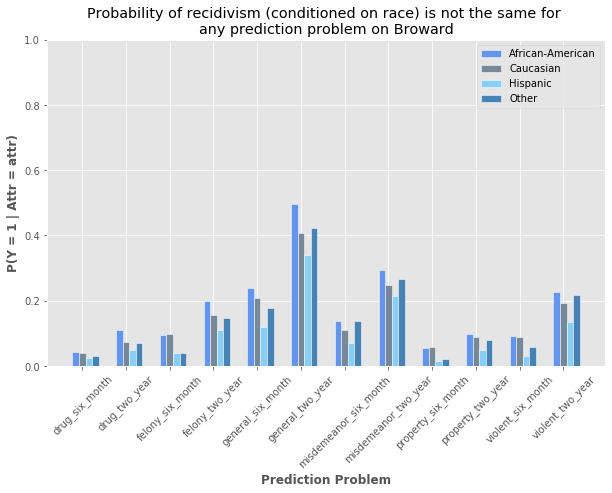

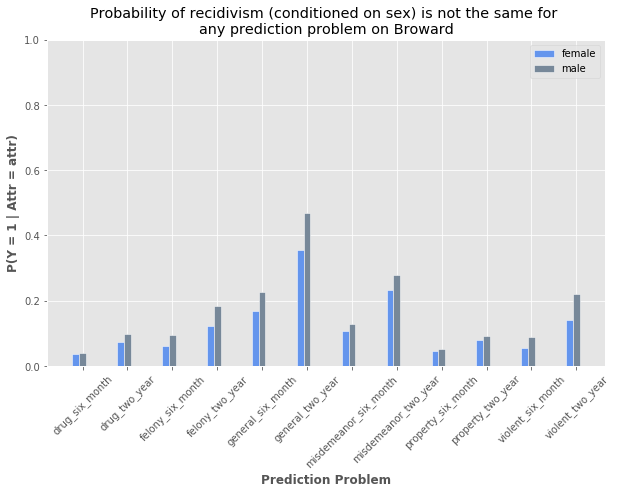

In [26]:
prob_recid_conditioned_sensitive_attr(broward_recid_balance_df, 
                                      "race", 
                                      dataset_name = "Broward",
                                      save_path = "broward/logs/fairness_results/data_visualizations/broward_prob_recid_conditioned_race.pdf")
prob_recid_conditioned_sensitive_attr(broward_recid_balance_df, 
                                      "sex", 
                                      dataset_name = "Broward",
                                      save_path = "broward/logs/fairness_results/data_visualizations/broward_prob_recid_conditioned_sex.pdf")

##### Same for Kentucky

In [22]:
total_inds = kentucky_data.shape[0]
# unpivot the sensitive attributes
kentucky_attrs = (pd.melt(kentucky_data, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                   .rename({'variable': 'Attribute',
                            'value': 'Attribute Value'},
                            axis=1)
                    # concatenate the label info 
                   .merge(kentucky_data[['person_id', 'screening_date'] + settings["kentucky_labels"]], 
                          on = ['person_id', 'screening_date'],
                          how = 'left'))

kentucky_recid_balance_groups = {}
for label in settings['kentucky_labels']:
    kentucky_attrs_label = kentucky_attrs[['person_id', 'screening_date', 'Attribute', 'Attribute Value'] + [label]]

    res = (kentucky_attrs_label.groupby(['Attribute', 'Attribute Value'])
                              .sum()[label]
                              .to_frame('n_inds_recid')
                              .reset_index())
    
    res['total_inds'] = total_inds
    total_inds_with_attr = (kentucky_attrs_label
                           .groupby(['Attribute', 'Attribute Value'])
                           .size()
                           .to_frame("total_inds_with_attr")
                           .reset_index())
    
    res = res.merge(total_inds_with_attr, on = ['Attribute', 'Attribute Value'], how='left')
    res['P(Y = 1 | Attr = attr)'] = res['n_inds_recid']/res['total_inds_with_attr']
    res['P(Y = 1,  Attr = attr)'] = res['n_inds_recid']/total_inds
    res['label'] = label
    
    res.set_index('label')
    kentucky_recid_balance_groups[label] = res

In [23]:
# merge dictionary into 1 df
kentucky_recid_balance_df = (pd.concat(kentucky_recid_balance_groups, axis=0)
                            .reset_index()
                            .iloc[:, 2:])[['label', 'Attribute', 'Attribute Value', 'P(Y = 1 | Attr = attr)']]
kentucky_recid_balance_df.head()

,label,Attribute,Attribute Value,P(Y = 1 | Attr = attr)
0,general_two_year,race,African-American,0.280404
1,general_two_year,race,Caucasian,0.274920
2,general_two_year,race,Other,0.110336
3,general_two_year,sex,female,0.248130
4,general_two_year,sex,male,0.283211


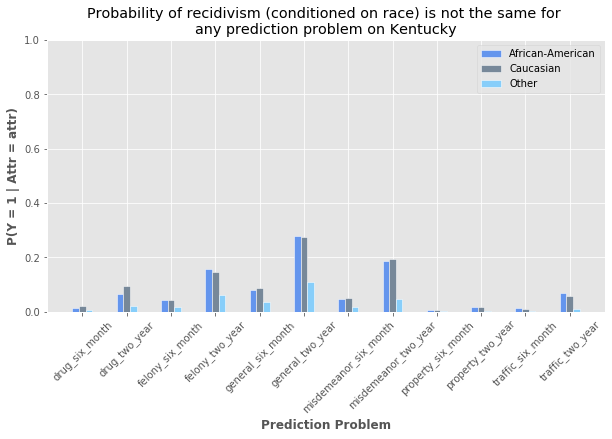

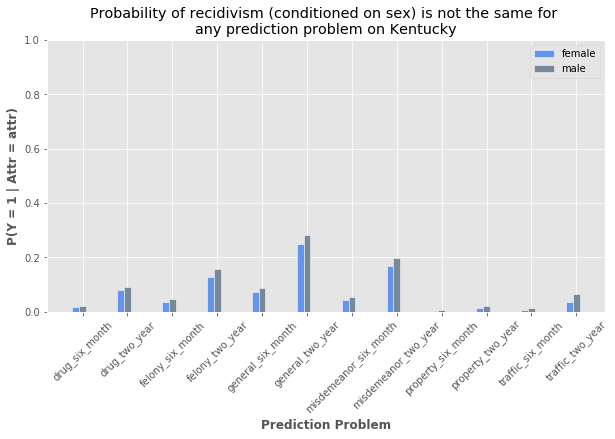

In [24]:
prob_recid_conditioned_sensitive_attr(kentucky_recid_balance_df, 
                                      "race", 
                                      dataset_name = "Kentucky",
                                      save_path = "kentucky/logs/fairness_results/data_visualizations/kentucky_prob_recid_conditioned_race.pdf")

prob_recid_conditioned_sensitive_attr(kentucky_recid_balance_df, 
                                      "sex", 
                                      dataset_name = "Kentucky",
                                      save_path = "kentucky/logs/fairness_results/data_visualizations/kentucky_prob_recid_conditioned_sex.pdf")